<a href="https://colab.research.google.com/github/m10singh94/ClassificationAndBoundingBoxPrediction/blob/main/ClassificationWithBoundingBoxPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cat and Dog Classification with Bounding Box Prediction
We will create a  `ViT model` using Transfer Learning to detect the class of image (either a dog or a cat) and also the bounding box, and try to demonstrate a demo of the model in Gradio in HuggingFace Space.

## 1 Starting with Importing all the files
* torch
* torchvision
* matplotlib
* torchinfo


In [1]:
# importing torch and torchvision
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


import matplotlib.pyplot as plt
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
from torchinfo import summary

from pathlib import Path
import os
import zipfile
import requests
import random
from PIL import Image
import numpy as np
from tqdm.auto import tqdm
from bs4 import BeautifulSoup
import cv2

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 2 Getting Data

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maitsingh","key":"b48511fa6d8df5b23fc91c558e9b263e"}'}

In [4]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list

ref                                                     title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/top-spotify-songs-2023                 Most Streamed Spotify Songs 2023                47KB  2023-08-26 11:04:57           5067        156  1.0              
joebeachcapital/students-performance                    Students Performance                             2KB  2023-08-31 00:50:11           1386         35  1.0              
nelgiriyewithana/global-youtube-statistics-2023         Global YouTube Statistics 2023                  60KB  2023-07-28 15:36:38          16048        535  1.0              
iamsouravbanerjee/airline-dataset                       Airline Dataset                                  4MB  2023-08-30 12:0

In [5]:
! kaggle datasets download -d andrewmvd/dog-and-cat-detection

100% 1.03G/1.03G [00:52<00:00, 20.6MB/s]
100% 1.03G/1.03G [00:52<00:00, 21.2MB/s]


In [8]:
data_path = Path("data/")
image_path = data_path / "cat_dog"

if image_path.is_dir():
  print(f"{image_path} exists.")
else:
  print(f"{image_path} doesn't exist, creating one.")
  image_path.mkdir(parents=True, exist_ok=True)

# As dataset's already downloaded, changing the directory
!mv ./dog-and-cat-detection.zip ./data/cat_dog/dog-and-cat-detection.zip

with zipfile.ZipFile(image_path / "dog-and-cat-detection.zip", "r") as zip_ref:
  print("Unzipping cat and dog...")
  zip_ref.extractall(image_path)
  print("Unzipping completed!")

!rm ./data/cat_dog/dog-and-cat-detection.zip
print("Directory ready to be used!")

data/cat_dog exists.
Unzipping cat and dog...
Unzipping completed!


## 3 Plot an image and it's bounding box

In [10]:
directory = image_path / 'annotations'
annotations = os.listdir(directory)

In [30]:
with open(os.path.join(directory,'Cats_Test0.xml'), 'r') as f:
        file = f.read()
data = BeautifulSoup(file, "xml")

objects = data.find_all('object')
length = len(objects)
filename = data.find("filename").text
img_width = int(data.find('size').width.text)
img_height = int(data.find('size').height.text)

xmin = int(objects[0].bndbox.xmin.text)
ymin = int(objects[0].bndbox.ymin.text)
xmax = int(objects[0].bndbox.xmax.text)
ymax = int(objects[0].bndbox.ymax.text)

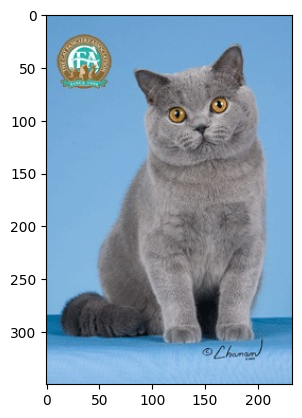

In [36]:
import cv2
img = cv2.imread(str(image_path) + "/images/Cats_Test0.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

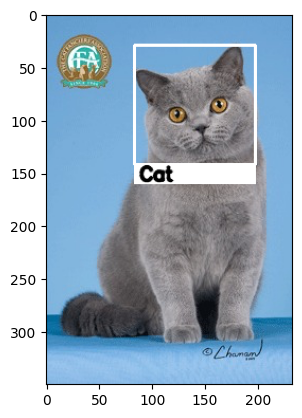

In [37]:
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.8
color=(0,0,0)
thickness=2

img = cv2.rectangle(img, (xmin, ymin), (xmax,ymax), (255,255,255), 2)
img = cv2.rectangle(img,(xmin,ymax),(xmax,ymax+18),(255,255,255),-1)
img = cv2.putText(img,"Cat",(xmin+5,ymax+15),font,fontScale-0.2,color,thickness,cv2.LINE_AA)

plt.imshow(img)

## 4 Preparing dataset
Converting `.xml` files to dataframes that can be used as dataset.